# Trade Data Background and Insights

https://ec.europa.eu/eurostat/web/international-trade-in-goods

International trade in goods statistics (ITGS) published by Eurostat measure the value and quantity of goods traded between the EU Member States and their trade partners. The data contain the import of three goods. 

Self-explanatory descriptions (https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=CN_2022&StrLanguageCode=EN&IntPcKey=&StrLayoutCode=HIERARCHIC&IntCurrentPage=1):
- Sunflower oil
    - index=0 15121191: Crude sunflower-seed oil (excl. for technical or industrial uses) 
    - index=1 15121990: Sunflower-seed or safflower oil and their fractions, whether or not refined, but not chemically modified (excl. for technical or industrial uses and crude)

- Maize corn:
    - index=0 10059000: Maize (excl. seed for sowing)
    
- Wheat:
    - index=0 100119: Durum wheat (excl. seed for sowing)
    - index=1 100199: Wheat and meslin (excl. seed for sowing, and durum wheat)
    - index=2 100810: Buckwheat

The data contains among others, the following four fields for the case:
- TIME_PERIOD: the month in which the goods were imported
- declarant: The country to where the goods are imported (3 = The Netherlands)
- partner: The country where the goods originate from.
- indicators: Indicates whether the value is the Quantity or the Value measure
- OBS_Value: the field that indicates the actual value.

#### Create Dataframe for each good 

In [2]:
import pandas as pd
import datetime

def process_csv(filepath, product_index):
    trade_data = pd.read_csv(filepath)

    trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
    trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
    trade_data = trade_data.drop_duplicates()
    #trade_data = trade_data.dropna()

    products = trade_data["product"].drop_duplicates().to_list()
    product_filter = products[product_index]

    partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")

    trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

    trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                                  columns='indicators', 
                                  values=['OBS_VALUE'])

    trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
    trade_data_pivot = trade_data_pivot.reset_index()
    trade_data_pivot = trade_data_pivot.dropna()

    df = trade_data_pivot
    df_product_filtered = df[df['product'] == product_filter]
    
    df_product_filtered = df_product_filtered.assign(OBS_VALUE_PER_METRIC_TON = (1000*df_product_filtered["OBS_VALUE_VALUE_1000EURO"]).div(df_product_filtered["OBS_VALUE_QUANTITY_TON"]))    
    
    return df_product_filtered
#Declare DataFrames for all good/productcode combinations
df_sunflower_oil_0 = process_csv("trade_data/sunflower_oil.csv", 0)
df_sunflower_oil_1 = process_csv("trade_data/sunflower_oil.csv", 1)
df_maize_corn_0 = process_csv("trade_data/maize_corn.csv", 0)
df_wheat_0 = process_csv("trade_data/wheat.csv", 0)
df_wheat_1 = process_csv("trade_data/wheat.csv", 1)
df_wheat_2 = process_csv("trade_data/wheat.csv", 2)


In [3]:
df_sunflower_oil_0

,PARTNER_Labels,TIME_PERIOD,product,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,OBS_VALUE_PER_METRIC_TON
0,Argentina,2005-01-01,15121191,21086.3,10489.97,497.477983
1,Argentina,2005-02-01,15121191,18325.9,8946.33,488.179571
2,Argentina,2005-03-01,15121191,25661.5,12741.53,496.523196
3,Argentina,2005-04-01,15121191,33839.2,16665.38,492.487411
4,Argentina,2005-05-01,15121191,41051.1,19921.35,485.281759
...,...,...,...,...,...,...
7476,United States,2022-07-01,15121191,3.8,6.01,1581.578947
7478,United States,2022-08-01,15121191,3.3,5.29,1603.030303
7480,United States,2022-09-01,15121191,13.1,20.82,1589.312977
7482,United States,2022-10-01,15121191,3.6,5.68,1577.777778


## Seasonality

## Top 10 partner countries for each good and every product (average (!!!) import quantity)

In [4]:
def get_means_list(df):
    # Select the columns to use
    df = df[["PARTNER_Labels", "OBS_VALUE_QUANTITY_TON"]]
    
    # Replace NaN values with 0
    df["OBS_VALUE_QUANTITY_TON"] = df["OBS_VALUE_QUANTITY_TON"].fillna(0)
    
    # Group the data by the unique values in "column1"
    grouped_df = df.groupby("PARTNER_Labels")

    # Take the mean of "column2" for each group
    means = grouped_df["OBS_VALUE_QUANTITY_TON"].mean()

    # Sort the means in descending order
    sorted_means = means.sort_values(ascending=False)

    # Save the means in a list
    means_list = list(zip(sorted_means.index, sorted_means))

    return means_list[:10]

# Call the function and store the result in a variable
means_list_sunflower_oil_0 = get_means_list(df_sunflower_oil_0)
means_list_sunflower_oil_1 = get_means_list(df_sunflower_oil_1)
means_list_maize_corn_0 = get_means_list(df_maize_corn_0)
means_list_wheat_0 = get_means_list(df_wheat_0)
means_list_wheat_1 = get_means_list(df_wheat_1)
means_list_wheat_2 = get_means_list(df_wheat_2)

dfs_and_means = [
    (df_sunflower_oil_0, means_list_sunflower_oil_0),
    (df_sunflower_oil_1, means_list_sunflower_oil_1),
    (df_maize_corn_0, means_list_maize_corn_0),
    (df_wheat_0, means_list_wheat_0),
    (df_wheat_1, means_list_wheat_1),
    (df_wheat_2, means_list_wheat_2),
]

# Create an empty list to store the rows of the final DataFrame
rows = []

# Iterate over the list of tuples and create a row for each dataframe
for df, means_list in dfs_and_means:
    # Create a dictionary with the data for the current row
    row = {
        '#1': means_list[0],
        '#2': means_list[1],
        '#3': means_list[2],
        '#4': means_list[3],
        '#5': means_list[4],
        '#6': means_list[5],
        '#7': means_list[6],
        '#8': means_list[7],
        '#9': means_list[8],
        '#10': means_list[9],
        # Add more columns here if needed
    }
    # Append the row to the list of rows
    rows.append(row)

# Create a DataFrame from the rows
df_means = pd.DataFrame(rows)

# Display the DataFrame (transpose)
df_top10 = df_means.T
df_top10.columns=['Crude sunflower-seed oil', 'Sunflower-seed or safflower oil', ' Maize', 'Durum wheat', 'Wheat and meslin', 'Buckwheat']
df_top10

C:\Users\basbe\AppData\Local\Temp\ipykernel_24988\715873767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OBS_VALUE_QUANTITY_TON"] = df["OBS_VALUE_QUANTITY_TON"].fillna(0)
C:\Users\basbe\AppData\Local\Temp\ipykernel_24988\715873767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OBS_VALUE_QUANTITY_TON"] = df["OBS_VALUE_QUANTITY_TON"].fillna(0)
C:\Users\basbe\AppData\Local\Temp\ipykernel_24988\715873767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,Crude sunflower-seed oil,Sunflower-seed or safflower oil,Maize,Durum wheat,Wheat and meslin,Buckwheat
#1,"(Ukraine, 20906.436842105264)","(Moldova, 4342.733333333334)","(Ukraine, 149147.13092105262)","(Germany, 7004.943076923077)","(France, 151817.47999999998)","(China, 255.92868852459017)"
#2,"(Argentina, 8412.71794871795)","(Ukraine, 2922.2754098360656)","(France, 97283.62523364487)","(United States, 5456.25)","(Germany, 87141.07384615384)","(Poland, 183.73541666666665)"
#3,"(Philippines, 6975.2)","(Belgium, 2769.3602803738318)","(Brazil, 54848.87810218978)","(Canada, 5141.782978723404)","(Belgium, 32241.18230769231)","(Lithuania, 159.36666666666667)"
#4,"(Hungary, 6268.249606299212)","(Germany, 2332.8271028037384)","(Germany, 33330.11915887851)","(Belgium, 4754.033076923078)","(Serbia, 22012.099999999995)","(New Zealand, 64.27777777777777)"
#5,"(Bolivia, 3119.2599999999998)","(France, 985.1616822429907)","(Romania, 31279.176229508197)","(Russia, 4400.0)","(United Kingdom, 15085.814728682171)","(Ukraine, 38.89)"
#6,"(Moldova, 2612.4285714285716)","(Spain, 330.0284615384615)","(Hungary, 18668.968691588783)","(France, 4113.1411290322585)","(Romania, 13922.781651376146)","(Russia, 37.334782608695654)"
#7,"(Russia, 2543.2250000000004)","(Romania, 232.9738095238095)","(Russia, 16452.49662921348)","(Ukraine, 3157.5)","(Latvia, 7272.2043478260875)","(Belarus, 21.866666666666664)"
#8,"(France, 2023.478971962617)","(United Kingdom, 212.25898876404494)","(Serbia, 15256.206976744186)","(Kazakhstan, 2256.733333333333)","(Russia, 7094.7475)","(India, 19.16)"
#9,"(Bulgaria, 1063.9737373737373)","(Hungary, 168.11353383458646)","(Canada, 15220.123529411765)","(Moldova, 338.875)","(Ukraine, 6505.112087912087)","(Czechia, 15.504651162790699)"
#10,"(Norway, 973.4)","(Austria, 146.18727272727273)","(Belgium, 14056.164018691588)","(Spain, 287.8175824175824)","(Denmark, 5902.565853658536)","(Germany, 14.912637362637362)"


In [5]:
import pandas as pd

def get_means_list(df):
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])
    df = df.groupby(['PARTNER_Labels', pd.Grouper(key='TIME_PERIOD', freq='M')]).mean()
    # Group the data by country and take the mean of 'OBS_VALUE_QUANTITY_TON' column
    grouped_df = df.groupby(level=0).mean()
    # Sort the means in descending order
    sorted_means = grouped_df["OBS_VALUE_QUANTITY_TON"].sort_values(ascending=False)
    # Save the means in a list
    means_list = list(zip(sorted_means.index, sorted_means))
    # Return the top 10 values
    return means_list[:10]

# Call the function and store the result in a variable
means_list_sunflower_oil_0 = get_means_list(df_sunflower_oil_0)
means_list_sunflower_oil_1 = get_means_list(df_sunflower_oil_1)
means_list_maize_corn_0 = get_means_list(df_maize_corn_0)
means_list_wheat_0 = get_means_list(df_wheat_0)
means_list_wheat_1 = get_means_list(df_wheat_1)
means_list_wheat_2 = get_means_list(df_wheat_2)

dfs_and_means = [
    (df_sunflower_oil_0, means_list_sunflower_oil_0),
    (df_sunflower_oil_1, means_list_sunflower_oil_1),
    (df_maize_corn_0, means_list_maize_corn_0),
    (df_wheat_0, means_list_wheat_0),
    (df_wheat_1, means_list_wheat_1),
    (df_wheat_2, means_list_wheat_2),
]

# Create an empty list to store the rows of the final DataFrame
rows = []

# Iterate over the list of tuples and create a row for each dataframe
for df, means_list in dfs_and_means:
    # Create a dictionary with the data for the current row
    row = {
        '#1': means_list[0],
        '#2': means_list[1],
        '#3': means_list[2],
        '#4': means_list[3],
        '#5': means_list[4],
        '#6': means_list[5],
        '#7': means_list[6],
        '#8': means_list[7],
        '#9': means_list[8],
        '#10': means_list[9],
        # Add more columns here if needed
    }
    # Append the row to the list of rows
    rows.append(row)

# Create a DataFrame from the rows
df_means = pd.DataFrame(rows)

# Display the DataFrame (transpose)
df_top10 = df_means.T
df_top10.columns=['Crude sunflower-seed oil', 'Sunflower-seed or safflower oil', ' Maize', 'Durum wheat', 'Wheat and meslin', 'Buckwheat']
df_top10


,Crude sunflower-seed oil,Sunflower-seed or safflower oil,Maize,Durum wheat,Wheat and meslin,Buckwheat
#1,"(Ukraine, 20906.436842105264)","(Moldova, 4342.733333333334)","(Ukraine, 149147.13092105262)","(Germany, 7004.943076923077)","(France, 151817.47999999998)","(China, 255.92868852459017)"
#2,"(Argentina, 8412.71794871795)","(Ukraine, 2922.2754098360656)","(France, 97283.62523364487)","(United States, 5456.25)","(Germany, 87141.07384615384)","(Poland, 183.73541666666665)"
#3,"(Philippines, 6975.2)","(Belgium, 2769.3602803738318)","(Brazil, 54848.87810218978)","(Canada, 5141.782978723404)","(Belgium, 32241.18230769231)","(Lithuania, 159.36666666666667)"
#4,"(Hungary, 6268.249606299212)","(Germany, 2332.8271028037384)","(Germany, 33330.11915887851)","(Belgium, 4754.033076923078)","(Serbia, 22012.099999999995)","(New Zealand, 64.27777777777777)"
#5,"(Bolivia, 3119.2599999999998)","(France, 985.1616822429907)","(Romania, 31279.176229508197)","(Russia, 4400.0)","(United Kingdom, 15085.814728682171)","(Ukraine, 38.89)"
#6,"(Moldova, 2612.4285714285716)","(Spain, 330.0284615384615)","(Hungary, 18668.968691588783)","(France, 4113.1411290322585)","(Romania, 13922.781651376146)","(Russia, 37.334782608695654)"
#7,"(Russia, 2543.2250000000004)","(Romania, 232.9738095238095)","(Russia, 16452.49662921348)","(Ukraine, 3157.5)","(Latvia, 7272.2043478260875)","(Belarus, 21.866666666666664)"
#8,"(France, 2023.478971962617)","(United Kingdom, 212.25898876404494)","(Serbia, 15256.206976744186)","(Kazakhstan, 2256.733333333333)","(Russia, 7094.7475)","(India, 19.16)"
#9,"(Bulgaria, 1063.9737373737373)","(Hungary, 168.11353383458646)","(Canada, 15220.123529411765)","(Moldova, 338.875)","(Ukraine, 6505.112087912087)","(Czechia, 15.504651162790699)"
#10,"(Norway, 973.4)","(Austria, 146.18727272727273)","(Belgium, 14056.164018691588)","(Spain, 287.8175824175824)","(Denmark, 5902.565853658536)","(Germany, 14.912637362637362)"


## Graphical Inspection

In [6]:
date_filter = datetime.date(year=2022,month=5,day=1)

### Ukraine's exports over time vs. other countries

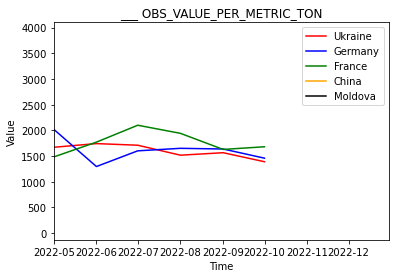

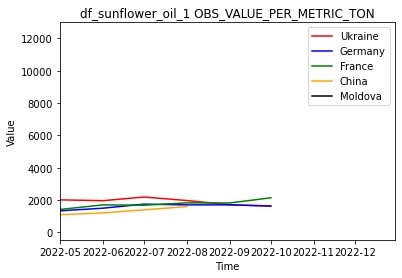

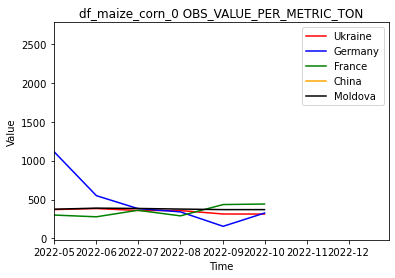

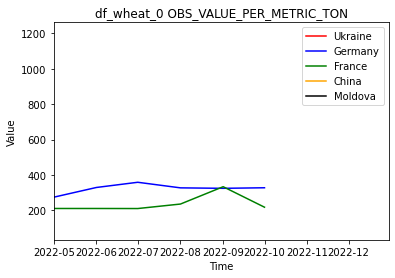

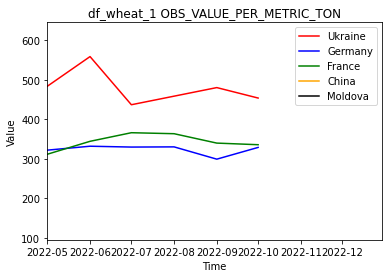

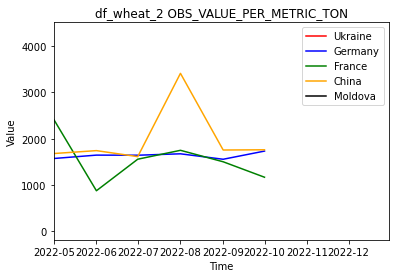

In [7]:
import matplotlib.pyplot as plt

# List of DataFrames
dataframes = [df_sunflower_oil_0, df_sunflower_oil_1, df_maize_corn_0, df_wheat_0, df_wheat_1, df_wheat_2]

# List of values for the 'Type' column
values = ['Ukraine', 'Germany', 'France', 'China', 'Moldova']

# List of colors
colors = ['red', 'blue', 'green', 'orange', 'black']

# Loop through each DataFrame
for df in dataframes:
    # Loop through each value
    for value, color in zip(values, colors):
        # Select the rows where the value in the 'Type' column is 'Specific Value'
        df_specific_value = df[(df['PARTNER_Labels'] == value)]
        # Make a line plot with time on the x-axis and the 'Value' column on the y-axis
        plt.plot(df_specific_value['TIME_PERIOD'], df_specific_value['OBS_VALUE_PER_METRIC_TON'], color=color)
        
    # Add a title and label the axes
    plt.title(next(k for k,v in locals().items() if v is df) + ' OBS_VALUE_PER_METRIC_TON')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(values)
    # Set the x-axis limits
    plt.xlim(date_filter, pd.Timestamp('2022-12-30'))

    # Display the plot
    plt.show()

### BELOW IS CODE JUNK

In [8]:
import pandas as pd
import datetime

trade_data = pd.read_csv("trade_data/wheat.csv")

trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
trade_data = trade_data.drop_duplicates()
#trade_data = trade_data.dropna()

products = trade_data["product"].drop_duplicates().to_list()
product_filter = products[1]

partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")

trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

df = trade_data_pivot


In [9]:
import pandas as pd
import datetime

trade_data = pd.read_csv("trade_data/maize_corn.csv")

trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
trade_data = trade_data.drop_duplicates()
#trade_data = trade_data.dropna()


In [10]:
products = trade_data["product"].drop_duplicates().to_list()
product_filter = products[0]

trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

print(products)
print(product_filter)

[10059000]
10059000


#### We've also included a file with the labels for all the partner countries:

In [11]:
partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")
print(partner_countries.head(7))

   PARTNER_codes  PARTNER_Labels
0              1          France
1              3     Netherlands
2              4         Germany
3              5           Italy
4              6  United Kingdom
5              7         Ireland
6              8         Denmark


#### View of the data:

In [12]:
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

print(trade_data.head(5))

               DATAFLOW        LAST UPDATE freq  DECLARANT_codes  \
0  ESTAT:DS-057380(1.0)  05/01/23 14:01:00    M                3   
1  ESTAT:DS-057380(1.0)  05/01/23 14:01:00    M                3   
2  ESTAT:DS-057380(1.0)  05/01/23 14:01:00    M                3   
3  ESTAT:DS-057380(1.0)  05/01/23 14:01:00    M                3   
4  ESTAT:DS-057380(1.0)  05/01/23 14:01:00    M                3   

   PARTNER_codes   product  flow  stat_regime    indicators TIME_PERIOD  \
0              1  10059000     1            1  QUANTITY_TON  2005-01-01   
1              1  10059000     1            1  QUANTITY_TON  2005-02-01   
2              1  10059000     1            1  QUANTITY_TON  2005-03-01   
3              1  10059000     1            1  QUANTITY_TON  2005-04-01   
4              1  10059000     1            1  QUANTITY_TON  2005-05-01   

   OBS_VALUE  OBS_FLAG PARTNER_Labels_x PARTNER_Labels_y  
0   106983.9       NaN           France           France  
1   126648.5       NaN

In [13]:

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

df = trade_data_pivot

KeyError: 'PARTNER_Labels'

In [ ]:
# Get a list of the unique values in the 'PARTNER_Labels' column
categories = df['PARTNER_Labels'].unique()

# Create an empty dictionary to store the results
results = {}

# Iterate over the categories
for category in categories:
  # Select rows where the value in the 'PARTNER_Labels' column is equal to the current category
  df_filtered = df[df['PARTNER_Labels'] == category]

  # Compute the mean of the 'Column2' column for the filtered data frame
  mean_value = df_filtered['OBS_VALUE_VALUE_1000EURO'].mean()

  # Add the mean value to the results dictionary
  results[category] = mean_value

# Sort the results in descending order
sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted results
print(sorted_results)

In [ ]:
print(trade_data_pivot.head(5000))

# Graphical Inspection Data

In [ ]:
date_filter = datetime.date(year=2018,month=1,day=1)
date_filter

## Ukraine

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = None
pd.options.display.max_columns = None

import datetime

# Select the rows where the value in the 'Type' column is 'Specific Value'
df_specific_value = df[(df['PARTNER_Labels'] == 'Ukraine') & (df['product'] == product_filter)]

# Make a line plot with time on the x-axis and the 'Value' column on the y-axis
plt.plot(df_specific_value['TIME_PERIOD'], df_specific_value['OBS_VALUE_QUANTITY_TON'])

# Add a title and label the axes
plt.title('Value (1000 Euro) over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# Set the x-axis limits
plt.xlim(date_filter, pd.Timestamp('2022-12-30'))

# Show the plot
plt.show()

df_specific_value

In [ ]:
df

#### Global Graph:

In [ ]:
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']

pd.options.display.max_rows = None
pd.options.display.max_columns = None


print(trade_data_total.head(5))

In [ ]:
trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter)&
                (trade_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_VALUE_1000EURO', 'OBS_VALUE_QUANTITY_TON']]\
.set_index('TIME_PERIOD').plot()

In [ ]:
trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter)&
                (trade_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'price']]\
.set_index('TIME_PERIOD').plot()

# Trade data

#### Graphs of specific Countries:

In [ ]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Germany')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()



In [ ]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Belgium')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()


In [ ]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()
